<a href="https://colab.research.google.com/github/9-coding/Graduation_Project/blob/main/clothing_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
import glob
import os

# 이미지와 마스크의 파일 경로를 가져옵니다.
image_paths = sorted(glob.glob('/content/gdrive/MyDrive/Colab Notebooks/graduation_project/archive/png_images/IMAGES/*.png'))
mask_paths = sorted(glob.glob('/content/gdrive/My Drive/Colab Notebooks/graduation_project/archive/png_masks/MASKS/*.png'))

# 이미지 경로의 파일 존재 여부를 확인합니다.
if image_paths:
    print("이미지 파일이 존재합니다.")
else:
    print("이미지 파일이 존재하지 않습니다.")

# 마스크 경로의 파일 존재 여부를 확인합니다.
if mask_paths:
    print("마스크 파일이 존재합니다.")
else:
    print("마스크 파일이 존재하지 않습니다.")


이미지 파일이 존재합니다.
마스크 파일이 존재합니다.


In [4]:
@tf.function
def load_image(image_path):
    file = tf.io.read_file(image_path)
    image = tf.image.decode_png(file, channels=3)
    return image


def load_mask(mask_path):
    file = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(file, channels=1)
    return mask

# image_paths와 mask_paths는 이미지 파일의 경로를 담고 있는 리스트로 가정합니다.
images = [load_image(image_path) for image_path in image_paths]
masks = [load_mask(mask_path) for mask_path in mask_paths]
print(len(images), len(masks))

1000 1000


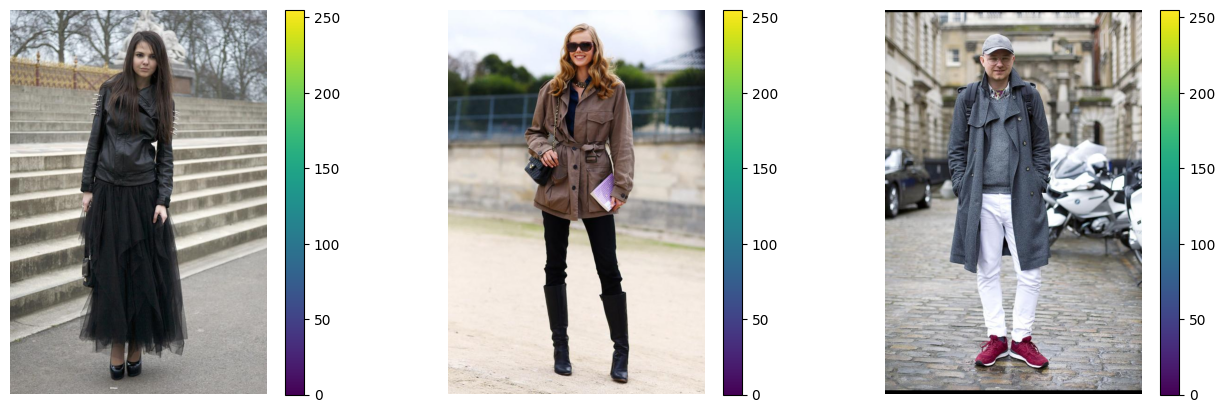

In [5]:
%matplotlib inline
# Sample few images and visualize
plt.figure(figsize=(16, 5))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis('off')
plt.show()

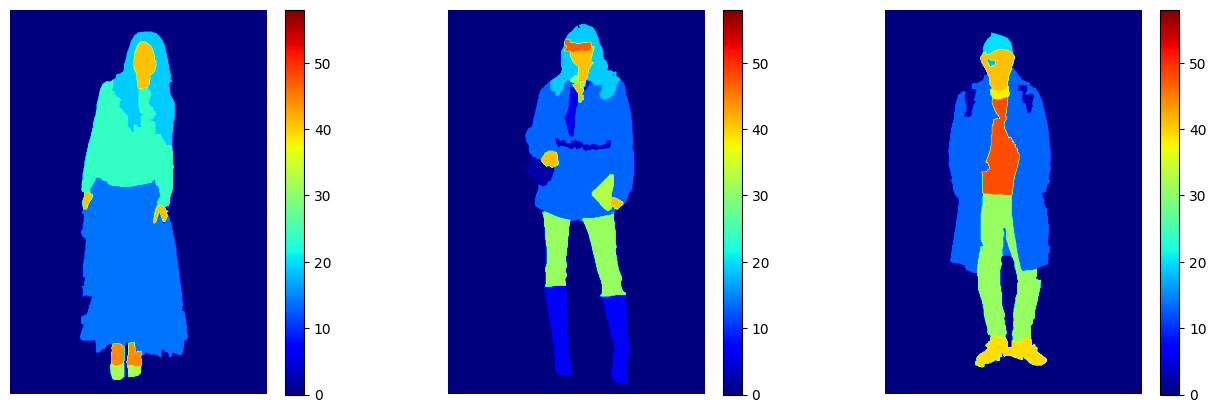

In [6]:
# Sample corresponding masks and visualize
NORM = mpl.colors.Normalize(vmin=0, vmax=58)

# plot masks
plt.figure(figsize=(16, 5))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(masks[i], cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [7]:
# Resize data as the model expects
def resize_and_normalize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)/255.0
    # resize the image
    image = tf.image.resize(image, (128, 128))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (128, 128))
    mask = tf.cast(mask, tf.uint8)
    return mask

X = [resize_and_normalize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]
print(len(X), len(y))

1000 1000


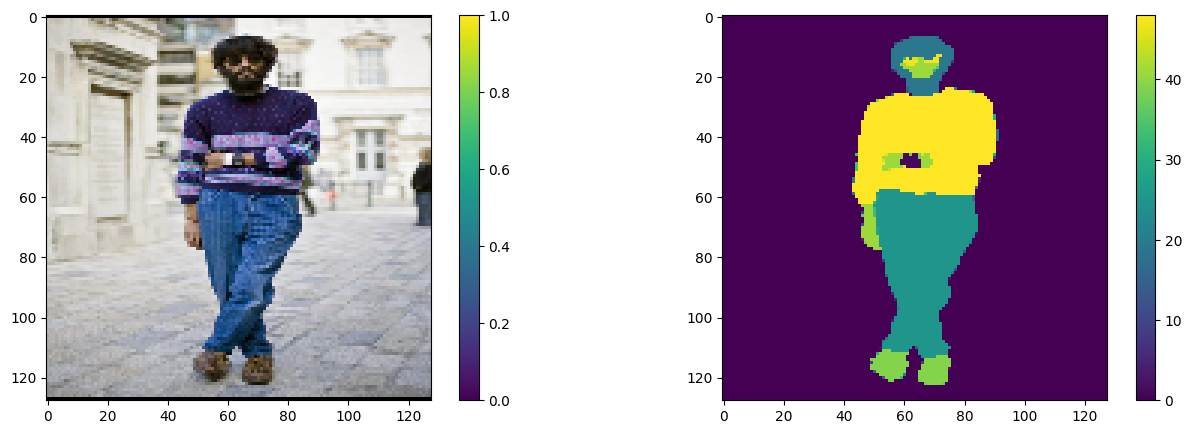

In [8]:
# Visualize a resized image and a resized mask
plt.figure(figsize=(16, 5))
# plot an image
plt.subplot(1, 2, 1)
plt.imshow(X[25])
plt.colorbar()

# plot a mask
plt.subplot(1, 2, 2)
plt.imshow(y[25])
plt.colorbar()
plt.show()

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=16)

In [10]:
# Data Argumentation Codes
def brigtness(img, mask):
    # adjust brigtness of image, don't alter in mask
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def hue(img, mask):
    # adjust hue of image, don't alter in mask
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    mask = tf.image.central_crop(mask, 0.7)
    img = tf.image.resize(img, (128, 128))
    mask = tf.image.resize(mask, (128, 128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_horizontal(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vertical(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    # rotate both image and mask identically
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [11]:
def preprocessing_data(train_X, test_X, train_y, test_y, BATCH_SIZE=64, BUFFER_SIZE=1000):
    train_X = tf.data.Dataset.from_tensor_slices(train_X.copy())
    test_X = tf.data.Dataset.from_tensor_slices(test_X.copy())
    train_y = tf.data.Dataset.from_tensor_slices(train_y.copy())
    test_y = tf.data.Dataset.from_tensor_slices(test_y.copy())
    # zip images and masks
    train = tf.data.Dataset.zip((train_X, train_y))
    test = tf.data.Dataset.zip((test_X, test_y))
    # Perform augmentation on train data only
    a = train.map(brigtness)
    b = train.map(hue)
    c = train.map(crop)
    d = train.map(flip_horizontal)
    e = train.map(flip_vertical)
    f = train.map(rotate)
    # Concatenate every new augmented data
    for aug_data in [a, b, c, d, e, f]:
        train = train.concatenate(aug_data)
    # shuffle and group the train set into batches
    train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    # do a prefetch to optimize processing
    train = train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # group the test set into batches
    test = test.batch(BATCH_SIZE)
    return train, test

train, test = preprocessing_data(train_X, test_X, train_y, test_y)

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
!pip install -q git+https://github.com/tensorflow/examples.git


  Preparing metadata (setup.py) ... done


In [14]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [15]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
OUTPUT_CLASSES = 59

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

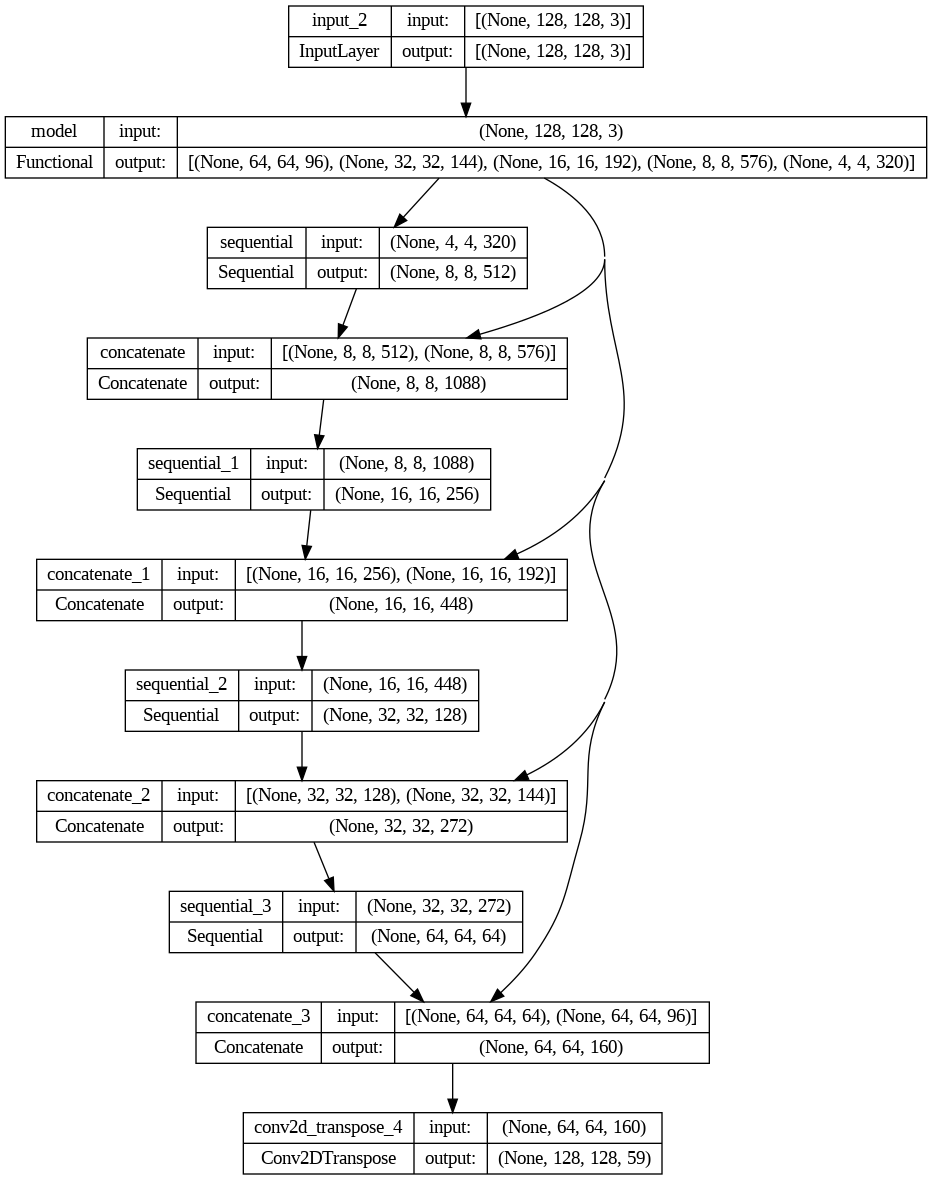

In [17]:
# Let plot our model
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
# configure the training parameters and train the model

TRAIN_LENGTH = 800
EPOCHS = 100
BATCH_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = 200//BATCH_SIZE

model_history = model.fit(train,
                          validation_data=test,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          epochs=EPOCHS,
                          verbose=2)

Epoch 1/100
6/6 - 27s - loss: 3.2813 - accuracy: 0.2818 - val_loss: 2.3976 - val_accuracy: 0.4590 - 27s/epoch - 5s/step
Epoch 2/100
6/6 - 1s - loss: 1.8534 - accuracy: 0.6878 - val_loss: 1.6065 - val_accuracy: 0.7343 - 1s/epoch - 228ms/step
Epoch 3/100
6/6 - 1s - loss: 1.3339 - accuracy: 0.7651 - val_loss: 1.5312 - val_accuracy: 0.7258 - 1s/epoch - 250ms/step
Epoch 4/100
6/6 - 2s - loss: 1.1751 - accuracy: 0.7612 - val_loss: 1.7041 - val_accuracy: 0.6812 - 2s/epoch - 255ms/step
Epoch 5/100
6/6 - 1s - loss: 1.2530 - accuracy: 0.7251 - val_loss: 1.3870 - val_accuracy: 0.7195 - 1s/epoch - 249ms/step
Epoch 6/100
6/6 - 1s - loss: 1.3710 - accuracy: 0.6889 - val_loss: 1.1885 - val_accuracy: 0.7468 - 1s/epoch - 245ms/step
Epoch 7/100
6/6 - 1s - loss: 1.3105 - accuracy: 0.6955 - val_loss: 1.0186 - val_accuracy: 0.7658 - 1s/epoch - 229ms/step
Epoch 8/100
6/6 - 1s - loss: 1.1252 - accuracy: 0.7346 - val_loss: 0.9225 - val_accuracy: 0.7865 - 1s/epoch - 224ms/step
Epoch 9/100
6/6 - 1s - loss: 1.03

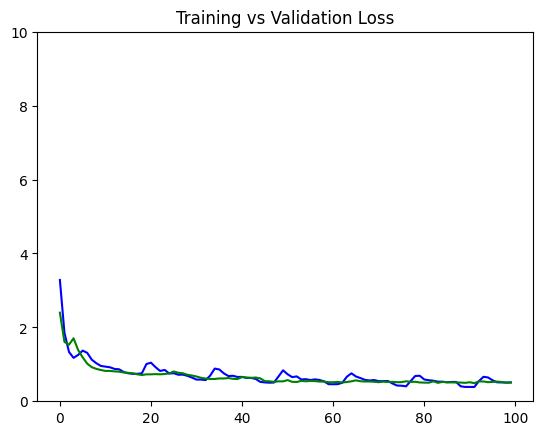

In [19]:
def plot_metrics(metric_name, title, ylim=5):
    '''plots a given metric from the model history'''
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], color='green',label='val_' + metric_name)

# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=10)

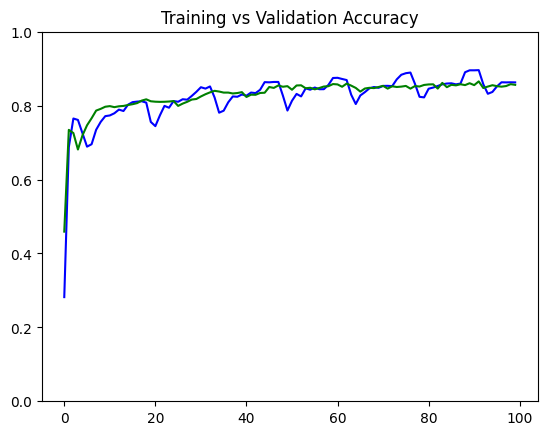

In [20]:
# Plot the training and validation accuracy
plot_metrics("accuracy", title="Training vs Validation Accuracy", ylim=1)

In [55]:
!pip install webcolors

In [58]:
!pip install colorthief

2/2 [==============================] - 0s 64ms/step


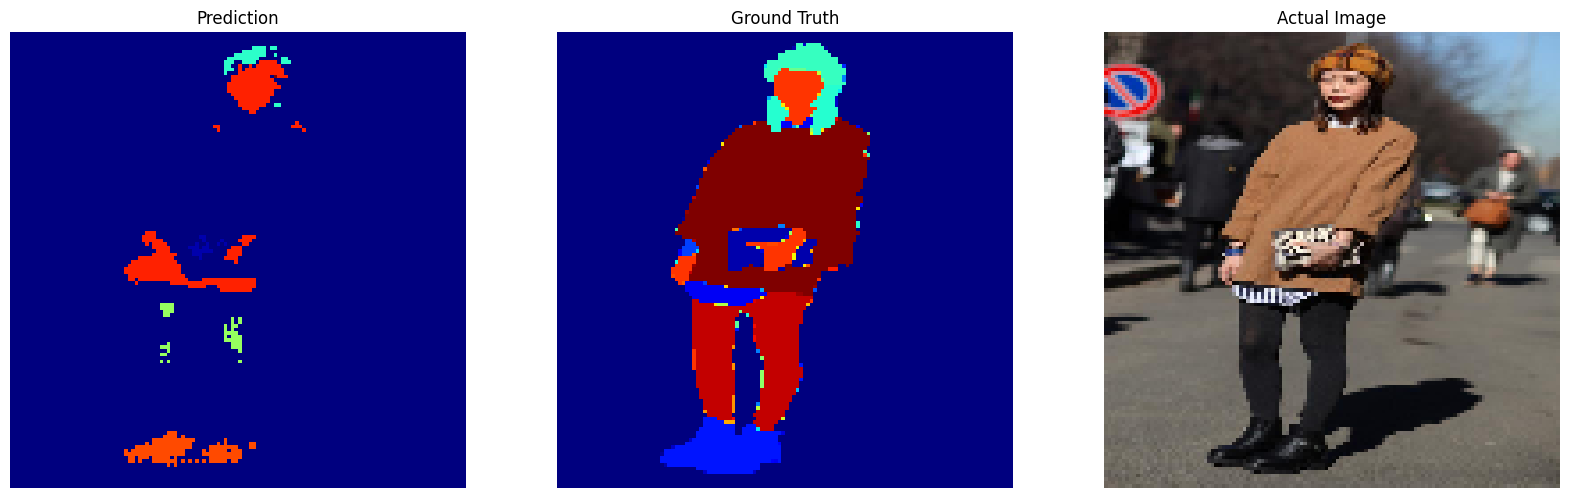

Black bag
[22.226166  15.8941345  6.9058533]

Black hair
[85.59894  41.414825 15.653107]

Black jeans
[25.071442 25.071442 27.071442]

Black shoes
[13.483796 13.316132 13.720276]

Black sunglasses
[30.127228 10.578309  0.      ]



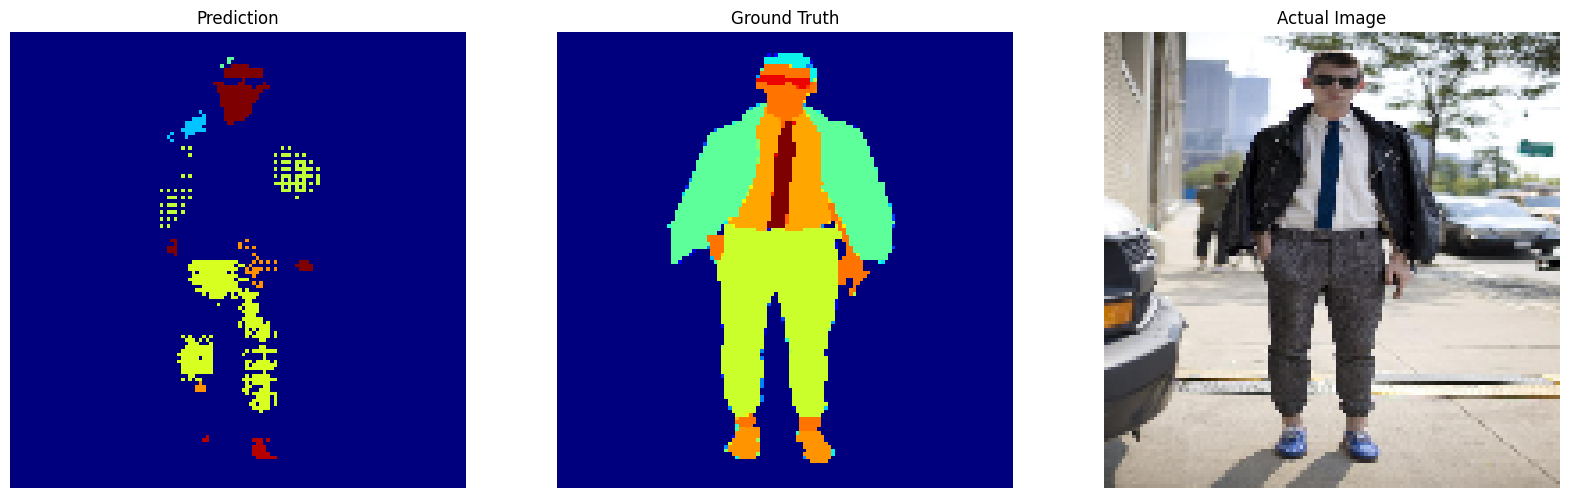

Black coat
[15.808595 16.808594 21.617188]

Black hair
[38.189148 34.553253 31.431887]

Black jacket
[43.304688 42.406254 47.101562]

Black jeans
[16.789062 15.789063 13.789063]

Black pants
[72.52125 67.52125 71.52125]

Black shoes
[45.838562 54.451843 84.49546 ]



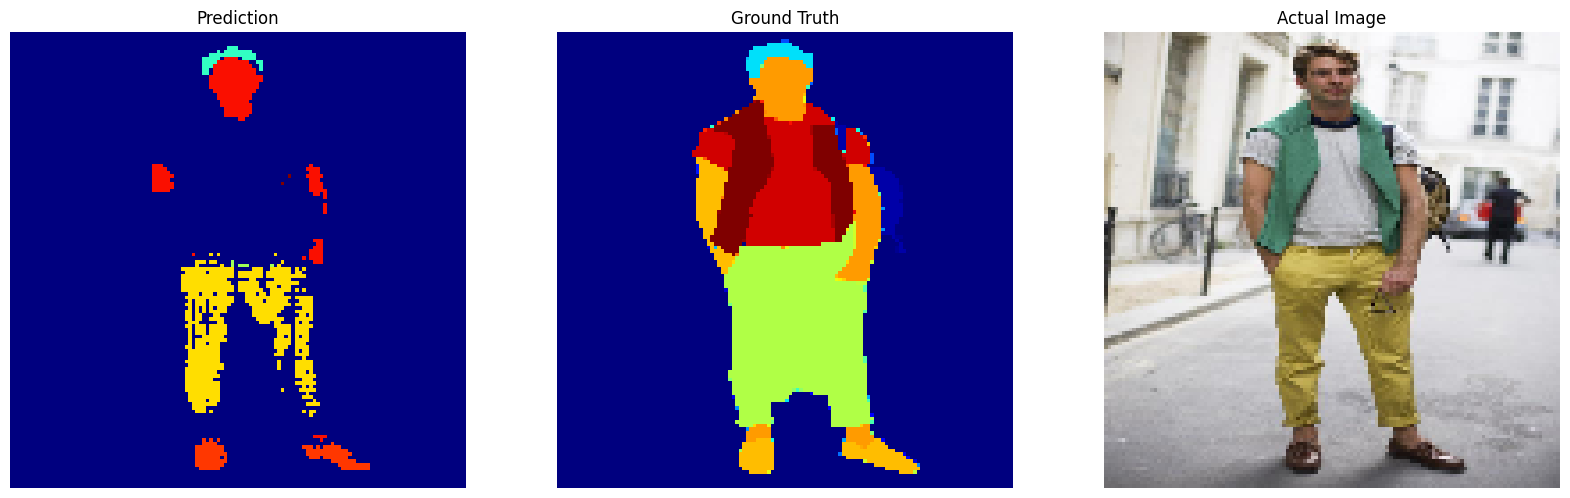

Black hair
[67.903076 58.71988  49.536682]

Pink jeans
[202.98438  183.98438   91.984375]

Pink pants
[195.6289  174.97726  97.65625]

Black shoes
[74.24265  49.109833 43.291416]

Black suit
[68.46759  98.0301   86.034004]



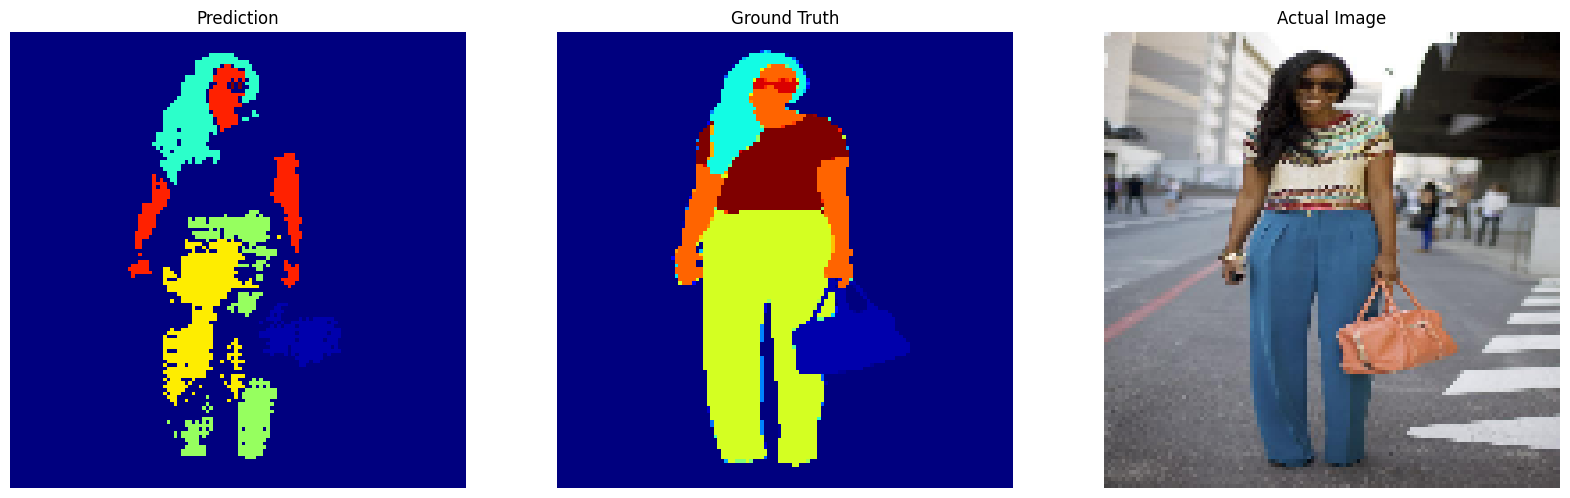

Pink bag
[223.2356  198.76358 181.81372]

Black hair
[57.409973 36.691223 16.011536]

Black jeans
[33. 56. 72.]

Blue pants
[ 56.128906  99.128914 141.1289  ]

Black sunglasses
[39.904694 27.270569 23.805206]



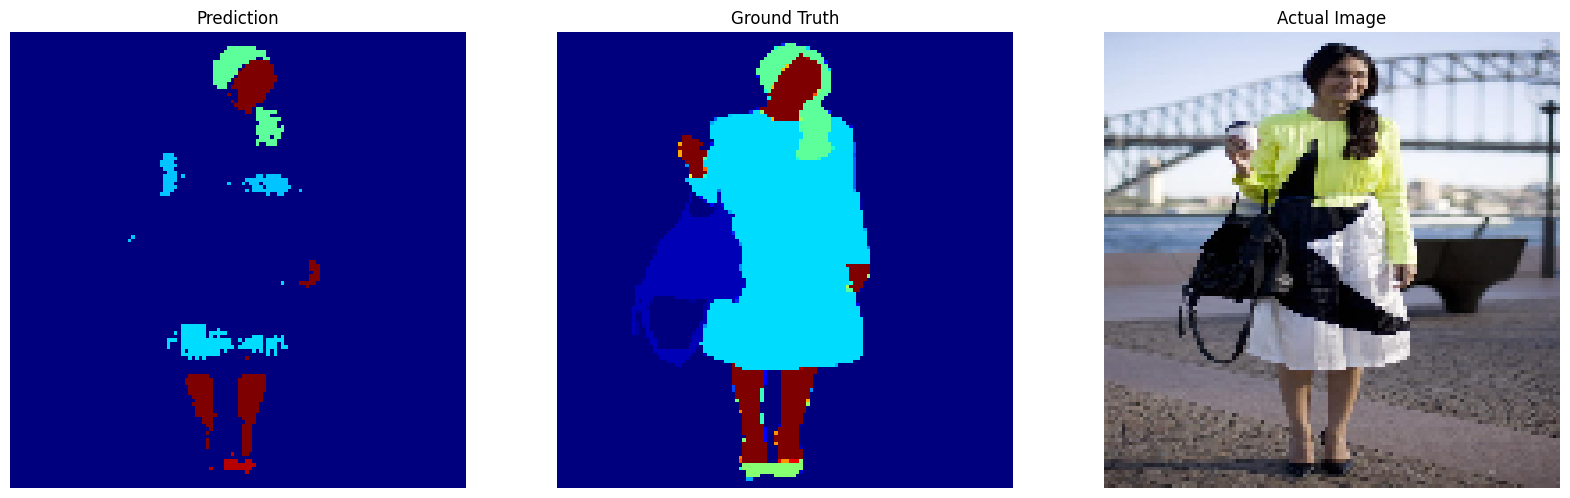

Black coat
[112.40735  119.38284   51.530457]

Pink dress
[166.67401 167.90839 178.99432]

Black hair
[ 6.3476562  6.3476562 16.347656 ]

Black shoes
[22.849945  14.4818125 19.490572 ]



In [80]:
import pandas as pd
import random
import webcolors
csv_file = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/graduation_project/archive/labels.csv')
class_names = list(tuple(csv_file['label_list']))
class_names[0] = 'background'
THRESHOLD = 0.6 # You can modify this value based on your requirement

def closest_color(rgb_values):
    # 0~255지만 입력을 고려하여 20~ 200으로 조정
    colors = {
        'Red': [255, 0, 0],
        'Green': [0, 255, 0],
        'Blue': [0, 0, 255],
        'Black': [0, 0, 0],
        'white': [255, 255, 255],
        'Yellow': [255, 255, 0],
        'Pink': [255, 192, 203]
    }

    min_distance = float('inf')
    closest = None

    for name, color in colors.items():
        distance = np.linalg.norm(np.array(rgb_values) - np.array(color))
        if distance < min_distance:
            min_distance = distance
            closest = name

    return closest

def predict_and_visualize(model, test, num_examples=5):
    img, mask = next(iter(test))
    pred = model.predict(img)
    for i in range(num_examples):
        # plot the predicted mask

        plt.figure(figsize=(20, 15))
        plt.subplot(1, 3, 1)
        probabilities = tf.nn.softmax(pred[i])  # Getting softmax probabilities
        predict = tf.argmax(pred[i], axis=-1)
        predict = np.array(predict)
        mask_high_confidence = np.max(probabilities, axis=-1) > THRESHOLD  # Creating a mask for high confidence pixels
        predict[~mask_high_confidence] = 0  # Assigning a background class to low confidence pixels
        plt.imshow(predict, cmap='jet')
        plt.axis('off')

        # Adding unique class labels present in the prediction
        unique_labels = np.unique(predict)
        # title = 'Prediction: ' + ', '.join([class_names[label] for label in unique_labels if label != 0])
        title = 'Prediction'
        plt.title(title)

        # plot the groundtruth mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[i], cmap='jet')
        plt.axis('off')
        plt.title('Ground Truth')

        # plot the actual image
        plt.subplot(1, 3, 3)
        plt.imshow(img[i])
        plt.axis('off')
        plt.title('Actual Image')

        plt.show()

        for n in unique_labels:
          position = np.where(predict == n)
          index = random.choice(list(zip(position[0], position[1])))
          img_array = np.array(img[i])
          color = img_array[index[0], index[1]] * 255
          color_name = closest_color(color)
          if n == 0 or n == 41: # ignore background and skin
            continue

          print(color_name, end=" ")
          print(class_names[n])
          print(color)
          print()



predict_and_visualize(model, test)

# https://pypi.org/project/extcolors/

In [22]:
# get the model prediction
results = model.predict(test)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)
print(results.shape)

4/4 [==============================] - 2s 391ms/step
(200, 128, 128)


In [23]:
def compute_metrics(y_true, y_pred, num_classes):
    '''
    Computes IOU and Dice Score.

    Args:
        y_true (tensor) - ground truth label map
        y_pred (tensor) - predicted label map
    '''

    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001
    y_true_reshape = np.reshape(y_true, y_pred.shape)

    for i in range(num_classes):
        intersection = np.sum((y_pred == i) * (y_true_reshape == i))
        y_true_area = np.sum(y_true_reshape == i)
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

In [24]:
# Get labels from csv file
import pandas as pd
csv_file = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/graduation_project/archive/labels.csv')
class_names = list(tuple(csv_file['label_list']))
class_names[0] = 'background'

In [25]:
# compute class-wise metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(test_y, results, len(class_names))

# print IOU for each class
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou))

background     0.9549827582768905 
accessories    3.179650228363592e-09 
bag            0.2619955184554264 
belt           0.002254158911653539 
blazer         0.007426698009535737 
blouse         0.0792457586344604 
bodysuit       1.141552498384104e-08 
boots          1.810938062638649e-09 
bra            1.1025358202587012e-08 
bracelet       8.818342073912328e-09 
cape           0.00037151826579378546 
cardigan       3.944773159981171e-09 
clogs          1.1402508421864215e-08 
coat           0.2971324171336099 
dress          0.3319395277721095 
earrings       1.230012284993699e-08 
flats          1.4084506843880186e-08 
glasses        1.3037809477994663e-08 
gloves         8.02568211857398e-09 
hair           0.4922997947480664 
hat            0.0025670968434840214 
heels          1.2738853340906328e-08 
hoodie         4.387889405932912e-09 
intimate       1.7857142538265315e-08 
jacket         0.11619321409193065 
jeans          0.20049637112383353 
jumper         0.0013722144058

In [26]:
# print the dice score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))

background     0.9769730748116474 
accessories    6.359300456727184e-09 
bag            0.41520831836874705 
belt           0.0044981782274439745 
blazer         0.014743897551582626 
blouse         0.14685396354977742 
bodysuit       2.283104996768208e-08 
boots          3.621876125277298e-09 
bra            2.2050716405174024e-08 
bracelet       1.7636684147824656e-08 
cape           0.0007427605833835596 
cardigan       7.889546319962342e-09 
clogs          2.280501684372843e-08 
coat           0.45813737013016986 
dress          0.49843032791149616 
earrings       2.460024569987398e-08 
flats          2.8169013687760372e-08 
glasses        2.6075618955989325e-08 
gloves         1.605136423714796e-08 
hair           0.6597867218599028 
hat            0.005121047474113018 
heels          2.5477706681812657e-08 
hoodie         8.775778811865824e-09 
intimate       3.571428507653063e-08 
jacket         0.2081955214461596 
jeans          0.3340224526630421 
jumper         0.002740668032

In [27]:
model.save('/content/gdrive/My Drive/graduation_project/fashion_unet_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(
